In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

In [4]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b289b6f9cf510e249e4189817e1efdf0554f42bacbafd451caaee58f56c87534
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [5]:
import shap
import lime
import lime.lime_tabular
import warnings
warnings.filterwarnings("ignore")

In [6]:
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Summary Statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469  

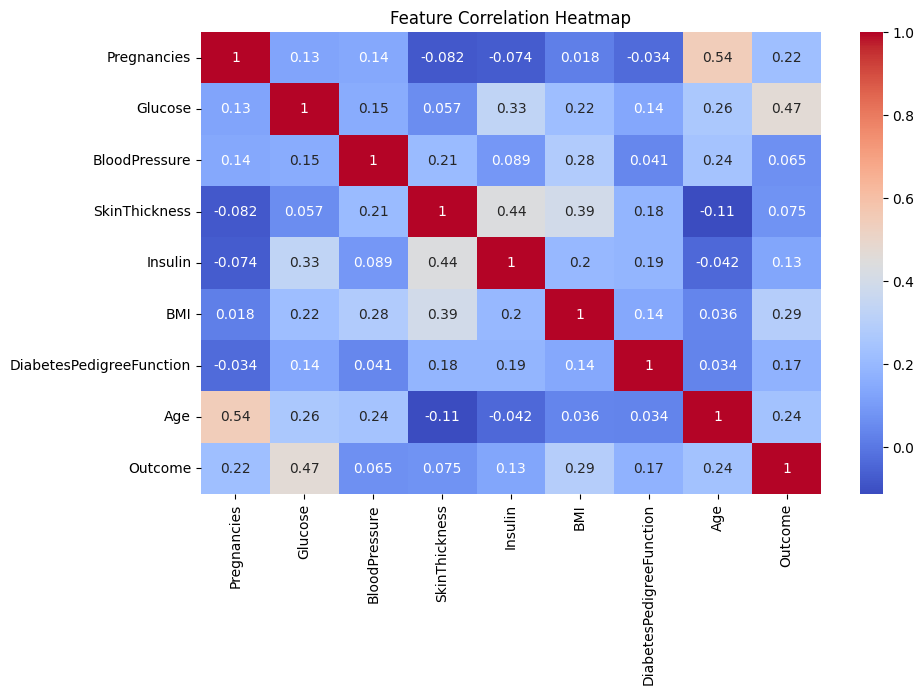

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    df[col] = df[col].replace(0, np.nan)
    df[col].fillna(df[col].median(), inplace=True)

In [10]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
lr = LogisticRegression()
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

models = {'Logistic Regression': lr, 'Random Forest': rf, 'XGBoost': xgb}

In [14]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    print(f"\n📘 {name} Results")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("ROC AUC:", roc_auc_score(y_test, preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print("Classification Report:\n", classification_report(y_test, preds))



📘 Logistic Regression Results
Accuracy: 0.7532467532467533
ROC AUC: 0.7232323232323232
Confusion Matrix:
 [[82 17]
 [21 34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154


📘 Random Forest Results
Accuracy: 0.7337662337662337
ROC AUC: 0.712121212121212
Confusion Matrix:
 [[78 21]
 [20 35]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.79      0.79        99
           1       0.62      0.64      0.63        55

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154


📘 XGBoost Results
Accuracy: 0.7142857142857143
ROC A

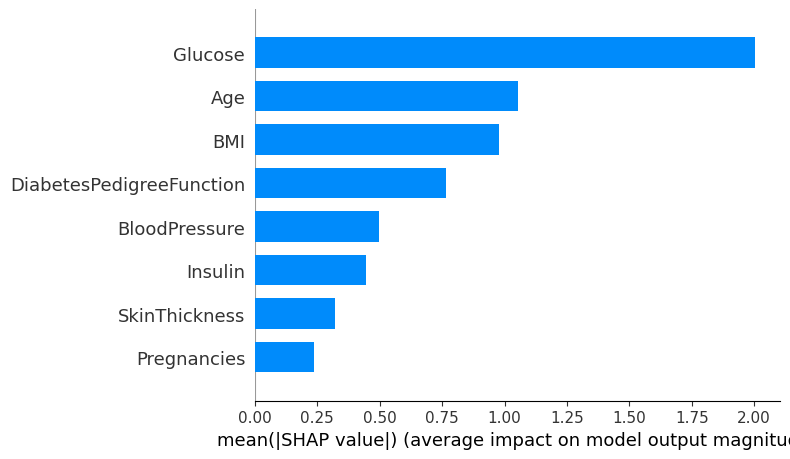

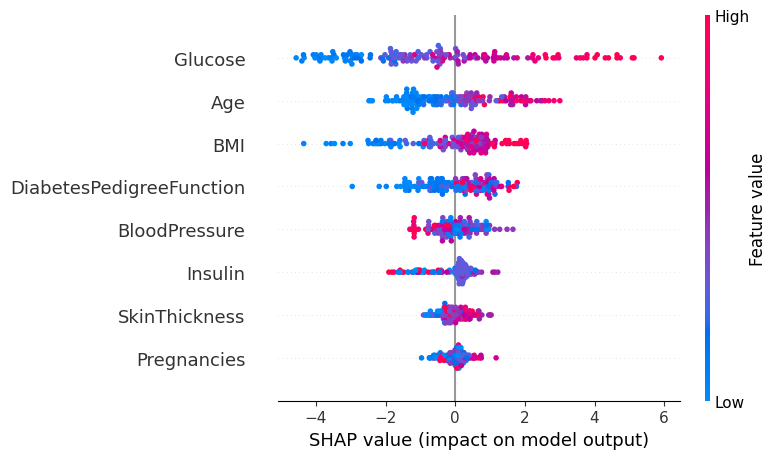

In [15]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)


In [17]:
# 9. LIME Explanation (on one test sample)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X.columns,
    class_names=['No Diabetes', 'Diabetes'],
    mode='classification'
)


In [18]:
sample_idx = 1
exp = explainer_lime.explain_instance(X_test_scaled[sample_idx], xgb.predict_proba, num_features=6)
exp.show_in_notebook(show_table=True)

In [19]:
import joblib
joblib.dump(xgb, "xgb_diabetes_model.pkl")
print("\n✅ XGBoost model saved as xgb_diabetes_model.pkl")


✅ XGBoost model saved as xgb_diabetes_model.pkl
